<a href="https://colab.research.google.com/github/anomaitech/GSL-basin/blob/main/GSL_Basin_outlier_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from google.colab import files
from IPython.display import display, clear_output
import geopandas as gpd
import io
import os
import zipfile

In [ ]:
#@markdown ### **Defining functions for this section**

# looks through columns in dataframe to find matches to use as default for widgets
def find_default_column(possible_names, columns):
    lower_columns = [column.lower() for column in columns]
    for name in possible_names:
        if name.lower() in lower_columns:
            return columns[lower_columns.index(name.lower())]
    return columns[0]

In [ ]:
#@markdown ### **Uploading wells file**
upload_wells = files.upload()
wells = pd.read_csv(list(upload_wells.keys())[0])

wList = list(wells.columns)
wList.append('NA')

# find defaults for widgets
default_w_ID = find_default_column(['WellID', 'Well_ID'], wList)
default_w_name = find_default_column(['WellName', 'Well_Name'], wList)
default_w_lat = find_default_column(['Latitude', 'Lat', 'lat_dec'], wList)
default_w_long = find_default_column(['Longitude', 'long', 'long_dec'], wList)
default_w_aquifer_ID = find_default_column(['AquiferID', 'Aquifer_ID'], wList)

w_well_ID = widgets.Dropdown(options=wList, value=default_w_ID, description = "Well ID")
w_well_name = widgets.Dropdown(options=wList, value=default_w_name, description = "Well Name")
w_lat = widgets.Dropdown(options=wList, value=default_w_lat, description = "Latitude")
w_long = widgets.Dropdown(options=wList, value=default_w_long, description = "Longitude")
w_aquifer_ID = widgets.Dropdown(options=wList, value=default_w_aquifer_ID, description = "Aquifer ID")

wItems = [w_well_ID, w_well_name, w_lat, w_long, w_aquifer_ID]
print("\nPlease select the appropriate headers for your file")
widgets.GridBox(wItems, layout=widgets.Layout(grid_template_columns="repeat(1, 550px)"))

Saving GSLB_1900-2023_wells_with_aquifers_with_Elev.csv to GSLB_1900-2023_wells_with_aquifers_with_Elev.csv

Please select the appropriate headers for your file


GridBox(children=(Dropdown(description='Well ID', options=('Well_ID', 'Well_Name', 'lat_dec', 'long_dec', 'GSE…

In [ ]:
wells_gdf = gpd.GeoDataFrame(wells, geometry=gpd.points_from_xy(wells[w_long.value], wells[w_lat.value]))


In [ ]:
wells.head()

,Well_ID,Well_Name,lat_dec,long_dec,GSE,AquiferID,Aquifer_Name,State,NASA_GSE,AW3D_GSE,Avg_GSE
0,381033113480701,(C-30-18)25aad- 1,38.175796,-113.802750,7098.0,1,GSL Basin,UT,7122.70364,7119.42280,7121.06322
1,381037113474001,(C-30-17)30bab- 1,38.176306,-113.795500,7193.0,1,GSL Basin,UT,7122.70364,7112.86112,7117.78238
2,381152113442801,(C-30-17)15cab- 1,38.197833,-113.741167,6550.0,1,GSL Basin,UT,6551.83748,6558.39916,6555.11832
3,381236113485601,(C-30-18)12cdb- 1,38.210028,-113.815500,7190.0,1,GSL Basin,UT,7178.47792,7194.88212,7186.68002
4,382113113435401,(C-28-17)22dda- 1,38.353571,-113.732473,5775.0,1,GSL Basin,UT,5784.12092,5787.40176,5785.76134


In [ ]:
wells_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8752 entries, 0 to 8751
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Well_ID       8752 non-null   int64   
 1   Well_Name     8752 non-null   object  
 2   lat_dec       8752 non-null   float64 
 3   long_dec      8752 non-null   float64 
 4   GSE           8752 non-null   float64 
 5   AquiferID     8752 non-null   int64   
 6   Aquifer_Name  8752 non-null   object  
 7   State         8752 non-null   object  
 8   NASA_GSE      8752 non-null   float64 
 9   AW3D_GSE      8752 non-null   float64 
 10  Avg_GSE       8752 non-null   float64 
 11  geometry      8752 non-null   geometry
dtypes: float64(6), geometry(1), int64(2), object(3)
memory usage: 820.6+ KB


In [ ]:

# Create (or recreate) a temporary directory to extract the shapefile
temp_dir = "temp_shapefile"
if os.path.exists(temp_dir):
    import shutil
    shutil.rmtree(temp_dir)
os.makedirs(temp_dir, exist_ok=True)

# Global variable to store the GeoDataFrame from the uploaded shapefile
uploaded_gdf = None

# Create a file upload widget that accepts only .zip files
upload_widget = widgets.FileUpload(
    accept='.zip',  # only accept zip files
    multiple=False  # allow only a single file upload
)

def on_upload_change(change):
    global uploaded_gdf  # so we can access it outside this function
    if upload_widget.value:
        # Get the uploaded file (only one file is allowed)
        uploaded_filename = list(upload_widget.value.keys())[0]
        print(f"Uploaded file: {uploaded_filename}")
        file_info = upload_widget.value[uploaded_filename]

        # Create a BytesIO object from the uploaded content
        zip_data = io.BytesIO(file_info['content'])

        # Extract the zip file into the temporary directory
        with zipfile.ZipFile(zip_data) as z:
            z.extractall(temp_dir)

        # Look for a .shp file within the extracted files
        shp_files = [f for f in os.listdir(temp_dir) if f.endswith('.shp')]
        if not shp_files:
            print("No shapefile (.shp) found in the extracted data.")
            return
        shp_path = os.path.join(temp_dir, shp_files[0])
        print(f"Found shapefile: {shp_path}")

        # Read the shapefile using GeoPandas and store it in the global variable
        uploaded_gdf = gpd.read_file(shp_path)
        print("Shapefile loaded successfully. You can now run the plotting cell.")

# Attach the observer callback to the widget
upload_widget.observe(on_upload_change, names='value')

# Display the widget so you can upload your zip file
display(upload_widget)


FileUpload(value={}, accept='.zip', description='Upload')

Uploaded file: gls_basin.zip
Found shapefile: temp_shapefile/gsl_basin.shp
Shapefile loaded successfully. You can now run the plotting cell.


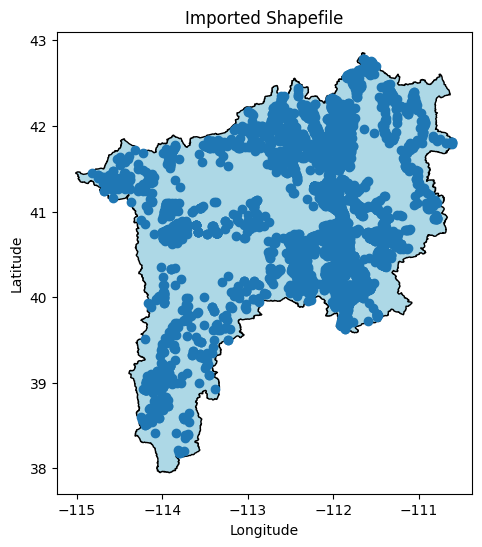

In [ ]:
def plot_uploaded_shapefile():
    if uploaded_gdf is None:
        print("No shapefile loaded. Please upload a zipped shapefile first.")
        return
    # Create a plot for the loaded shapefile
    fig, ax = plt.subplots(figsize=(10, 6))
    uploaded_gdf.plot(ax=ax, edgecolor='black', facecolor='lightblue')
    # If you have another GeoDataFrame (e.g., wells_gdf) to overlay, plot it here:
    wells_gdf.plot(ax=ax)
    ax.set_title("Imported Shapefile")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

# Call this function when you're ready to display the plot
plot_uploaded_shapefile()


In [ ]:
# prompt: find the bbox

import geopandas as gpd

# Assuming 'uploaded_gdf' is your GeoDataFrame from the uploaded shapefile
# and it has a geometry column
if uploaded_gdf is not None:
    bbox = uploaded_gdf.total_bounds
    print(f"Bounding box: {bbox}") # minx, miny, maxx, maxy

    # Example usage: creating a bounding box polygon
    from shapely.geometry import Polygon
    bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])
    bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox_polygon], crs=uploaded_gdf.crs)

    # Now you have bbox_gdf which contains a polygon of your bounding box.
    # You can plot this on your map, for instance.


Bounding box: [-115.00992021   37.94716302 -110.59847552   42.85578334]


In [ ]:
#@markdown ### **Uploading timeseries**
upload_timeseries = files.upload()
measurements = pd.read_csv(list(upload_timeseries.keys())[0])

tList = list(measurements.columns)
tList.append('NA')

default_t_well_ID = find_default_column(['WellID', 'Well_ID'], tList)
default_t_date = find_default_column(['Date'], tList)
default_t_measurement = find_default_column(['WTE'], tList)
default_t_aquifer_ID = find_default_column(['AquiferID', 'Aquifer_ID'], tList)

ts_well_ID = widgets.Dropdown(options=tList, value=default_t_well_ID, description = "Well ID")
ts_date = widgets.Dropdown(options=tList, value=default_t_date, description = "Date")
ts_measurement = widgets.Dropdown(options=tList, value=default_t_measurement, description = "Measurement")
ts_aquifer_ID = widgets.Dropdown(options=tList, value=default_t_aquifer_ID, description = "Aquifer ID")

tItems = [ts_well_ID, ts_date, ts_measurement, ts_aquifer_ID]

print("\nPlease select the appropriate headers for your file")
widgets.GridBox(tItems, layout=widgets.Layout(grid_template_columns="repeat(1, 550px)"))

Saving GSLB_1900-2023_TS_with_aquifers.csv to GSLB_1900-2023_TS_with_aquifers.csv

Please select the appropriate headers for your file


GridBox(children=(Dropdown(description='Well ID', index=1, options=('AquiferID', 'Well_ID', 'Date', 'WTE', 'St…

In [ ]:
unique_wells=wells_gdf['Well_ID'].unique()

minimum_sample_size=0
maximum_sample_size=100
filtered_well_size=2000

In [ ]:

filtered_wells_info={}

In [ ]:
wells.head()

,Well_ID,Well_Name,lat_dec,long_dec,GSE,AquiferID,Aquifer_Name,State,NASA_GSE,AW3D_GSE,Avg_GSE
0,381033113480701,(C-30-18)25aad- 1,38.175796,-113.802750,7098.0,1,GSL Basin,UT,7122.70364,7119.42280,7121.06322
1,381037113474001,(C-30-17)30bab- 1,38.176306,-113.795500,7193.0,1,GSL Basin,UT,7122.70364,7112.86112,7117.78238
2,381152113442801,(C-30-17)15cab- 1,38.197833,-113.741167,6550.0,1,GSL Basin,UT,6551.83748,6558.39916,6555.11832
3,381236113485601,(C-30-18)12cdb- 1,38.210028,-113.815500,7190.0,1,GSL Basin,UT,7178.47792,7194.88212,7186.68002
4,382113113435401,(C-28-17)22dda- 1,38.353571,-113.732473,5775.0,1,GSL Basin,UT,5784.12092,5787.40176,5785.76134


In [ ]:
measurements_info = pd.merge(measurements, wells[['Well_ID','Avg_GSE','NASA_GSE','AW3D_GSE']], on='Well_ID', how='left')

In [ ]:

measurements_info['outlier']=1

In [ ]:
info=measurements_info[measurements_info['Avg_GSE']<measurements_info['WTE']]

In [ ]:
info['elevation_difference']=info['Avg_GSE']-info['WTE']

<ipython-input-14-6e76a300bf1f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info['elevation_difference']=info['Avg_GSE']-info['WTE']


In [ ]:
info['year']=info['Date'].str[:4]
info['month']=info['Date'].str[5:7]

<ipython-input-15-6081d9b9e74f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info['year']=info['Date'].str[:4]
<ipython-input-15-6081d9b9e74f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info['month']=info['Date'].str[5:7]


In [ ]:
info.head()

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,outlier,elevation_difference,year,month
1,1,381037113474001,2012-09-06,7175.95,UT,7117.78238,7122.70364,7112.86112,1,-58.16762,2012,09
452,1,384900114003001,1950-11-01,5395.00,UT,5388.77970,5387.13928,5390.42012,1,-6.22030,1950,11
1263,1,390530113590001,1936-11-01,5086.00,UT,5000.00016,4993.43848,5006.56184,1,-85.99984,1936,11
1352,1,390600113591501,1936-10-01,5073.00,UT,4990.15764,4986.87680,4993.43848,1,-82.84236,1936,10
1353,1,390600114021501,1981-08-26,5075.35,UT,5070.53822,5062.33612,5078.74032,1,-4.81178,1981,08


In [ ]:
original_info_2002_2009=info[(info['year'].astype(int)>=2000)&(info['year'].astype(int)<=2009)]
original_info_2010_2023=info[(info['year'].astype(int)>=2010)&(info['year'].astype(int)<=2023)]


In [ ]:
original_info_2010_2023

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,outlier,elevation_difference,year,month
1,1,381037113474001,2012-09-06,7175.95,UT,7117.78238,7122.70364,7112.86112,1,-58.16762,2012,09
2617,1,391322114000001,2010-06-17,4977.27,UT,4968.83218,4963.91092,4973.75344,1,-8.43782,2010,06
2621,1,391322114000001,2011-06-16,4973.90,UT,4968.83218,4963.91092,4973.75344,1,-5.06782,2011,06
3216,1,393331113533001,2010-03-03,4786.48,UT,4781.82430,4776.90304,4786.74556,1,-4.65570,2010,03
3217,1,393331113533002,2010-03-03,4786.85,UT,4781.82430,4776.90304,4786.74556,1,-5.02570,2010,03
...,...,...,...,...,...,...,...,...,...,...,...,...
176013,1,385503114062201,2010-01-16,5893.86,NV,5889.10780,5885.82696,5892.38864,1,-4.75220,2010,01
176014,1,385503114062201,2017-10-03,5889.49,NV,5889.10780,5885.82696,5892.38864,1,-0.38220,2017,10
176037,1,385941114032901,2010-03-16,5166.47,NV,5165.68258,5164.04216,5167.32300,1,-0.78742,2010,03
176061,1,390109114040201,2010-03-16,5154.32,NV,5129.59334,5131.23376,5127.95292,1,-24.72666,2010,03


In [ ]:
info_avearage=info.groupby('year')[['WTE','Avg_GSE','elevation_difference']].mean()

In [ ]:
info_2002_2009=info_avearage.loc['2002':'2009']
info_2010_2023=info_avearage.loc['2010':'2023']

In [ ]:
info_2002_2009['WTE']

,WTE
year,
2002,5273.931905
2003,5360.684091
2004,5284.191739
2005,5338.130000
2006,5194.825000
2007,5088.485556
2008,5118.738333
2009,5401.308182


In [ ]:
info_2010_2023

,WTE,Avg_GSE,elevation_difference
year,,,
2010,5337.790000,5313.437553,-24.352447
2011,5410.792222,5377.479029,-33.313193
2012,5897.153750,5854.658980,-42.494770
2013,5773.262222,5480.825489,-292.436733
2014,5751.305000,5708.114793,-43.190207
2015,6051.482000,5999.672108,-51.809892
2016,5751.295000,5708.114793,-43.180207
2017,5475.068889,5443.278098,-31.790791
2018,5565.948571,5520.716337,-45.232234


<Axes: xlabel='year'>

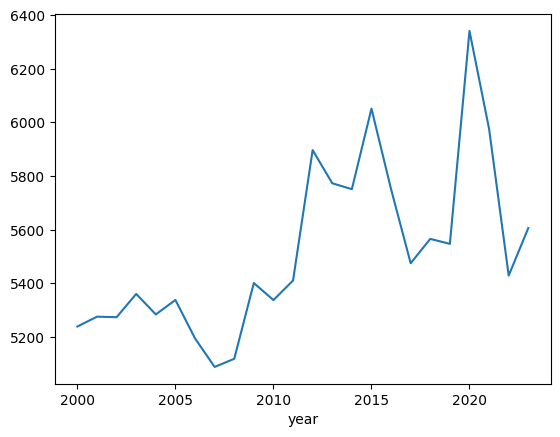

In [ ]:
info_avearage.loc['2000':'2023']['WTE'].plot()

In [ ]:
measurements_info['year']=measurements_info['Date'].str[:4]
measurements_info['month']=measurements_info['Date'].str[5:7]
measurements_info['elevation_difference']=measurements_info['Avg_GSE']-measurements_info['WTE']

In [ ]:
measurements_info_average=measurements_info.groupby('year')[['WTE','Avg_GSE','elevation_difference']].mean()

<Axes: xlabel='year'>

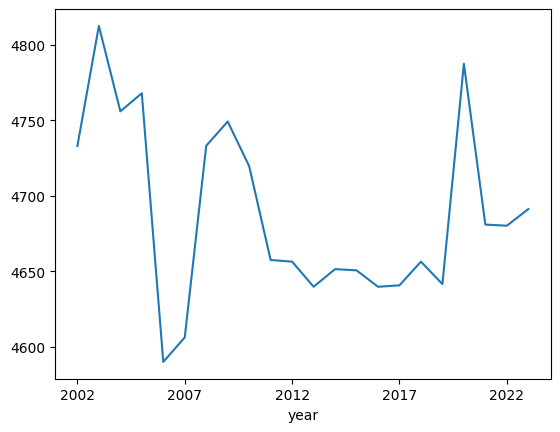

In [ ]:
measurements_info_average
measurements_info_average.loc['2002':'2023']['WTE'].plot()

In [ ]:
extreme_outlier=info[info['elevation_difference']<-50]

In [ ]:
extreme_outlier['elevation_difference'].max()

-50.02440000000024

In [ ]:
# prompt: for extreme outlier use  the elevation difference -30 for years between 2002 to 2009 else use -20, extreme_outlier=info[info['elevation_difference']<-20]

# Apply the conditional logic for outlier definition
info['extreme_outlier'] = 0  # Initialize a new column for extreme outliers
info.loc[((info['year'].astype(int) >= 2002) & (info['year'].astype(int) <= 2009)) & (info['elevation_difference'] < -50), 'extreme_outlier'] = 1
info.loc[~(((info['year'].astype(int) >= 2002) & (info['year'].astype(int) <= 2009))) & (info['elevation_difference'] < -20), 'extreme_outlier'] = 1

# Now 'extreme_outlier' column will have 1 for extreme outliers based on your criteria
extreme_outlier = info[info['extreme_outlier'] == 1]


In [ ]:
extreme_outlier

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,outlier,elevation_difference,year,month,extreme_outlier
1,1,381037113474001,2012-09-06,7175.95,UT,7117.78238,7122.70364,7112.86112,1,-58.16762,2012,09,1
1263,1,390530113590001,1936-11-01,5086.00,UT,5000.00016,4993.43848,5006.56184,1,-85.99984,1936,11,1
1352,1,390600113591501,1936-10-01,5073.00,UT,4990.15764,4986.87680,4993.43848,1,-82.84236,1936,10,1
9773,1,395310111530101,1965-04-08,4981.00,UT,4945.86630,4940.94504,4950.78756,1,-35.13370,1965,04,1
9774,1,395310111530101,1965-11-19,4987.40,UT,4945.86630,4940.94504,4950.78756,1,-41.53370,1965,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176612,1,412641114260301,1967-06-20,6304.43,NV,6225.39390,6233.59600,6217.19180,1,-79.03610,1967,06,1
176642,1,412726114110701,1956-09-13,5970.00,NV,5026.24688,5019.68520,5032.80856,1,-943.75312,1956,09,1
176645,1,412835114120501,1957-04-25,5077.00,NV,5049.21276,5052.49360,5045.93192,1,-27.78724,1957,04,1
176650,1,413249114292901,1955-08-19,5595.00,NV,5398.62222,5390.42012,5406.82432,1,-196.37778,1955,08,1


In [ ]:
extreme_outlier

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,outlier,elevation_difference,year,month
1,1,381037113474001,2012-09-06,7175.95,UT,7117.78238,7122.70364,7112.86112,1,-58.16762,2012,09
1263,1,390530113590001,1936-11-01,5086.00,UT,5000.00016,4993.43848,5006.56184,1,-85.99984,1936,11
1352,1,390600113591501,1936-10-01,5073.00,UT,4990.15764,4986.87680,4993.43848,1,-82.84236,1936,10
9773,1,395310111530101,1965-04-08,4981.00,UT,4945.86630,4940.94504,4950.78756,1,-35.13370,1965,04
9774,1,395310111530101,1965-11-19,4987.40,UT,4945.86630,4940.94504,4950.78756,1,-41.53370,1965,11
...,...,...,...,...,...,...,...,...,...,...,...,...
176642,1,412726114110701,1956-09-13,5970.00,NV,5026.24688,5019.68520,5032.80856,1,-943.75312,1956,09
176645,1,412835114120501,1957-04-25,5077.00,NV,5049.21276,5052.49360,5045.93192,1,-27.78724,1957,04
176646,1,412835114120501,2002-07-24,5069.76,NV,5049.21276,5052.49360,5045.93192,1,-20.54724,2002,07
176650,1,413249114292901,1955-08-19,5595.00,NV,5398.62222,5390.42012,5406.82432,1,-196.37778,1955,08


In [ ]:
info_outlier_years = info['year'].value_counts()
extreme_outlier_years = extreme_outlier['year'].value_counts()
extreme_outlier_years


,count
year,
1968,45
1967,39
1965,37
1966,35
1969,27
...,...
1935,1
1941,1
2023,1


<ipython-input-58-71f659b74812>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info['decade'] = (info['year'].astype(int) // 10) * 10
<ipython-input-58-71f659b74812>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_outlier['decade'] = (extreme_outlier['year'].astype(int) // 10) * 10


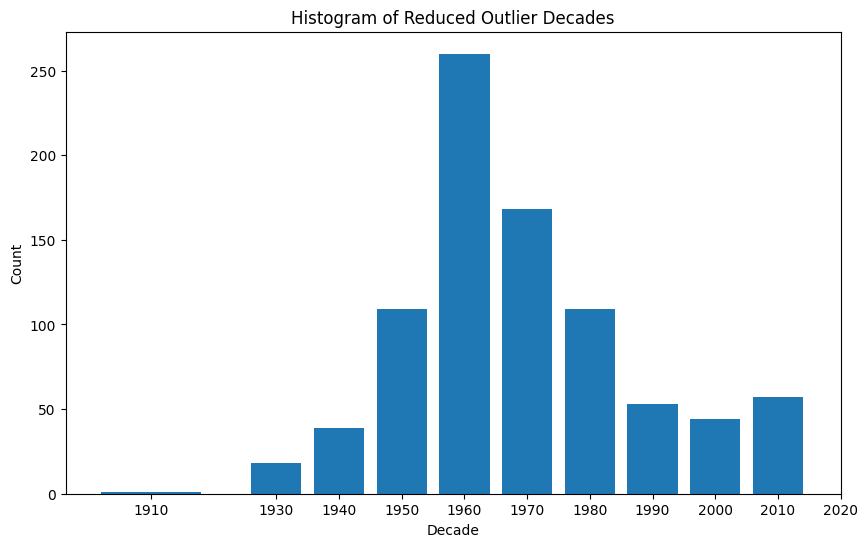

In [ ]:


plt.figure(figsize=(10, 6))
# Assuming 'info' DataFrame has a 'year' column
# Extract the decade from the year
info['decade'] = (info['year'].astype(int) // 10) * 10
extreme_outlier['decade'] = (extreme_outlier['year'].astype(int) // 10) * 10
# Count occurrences of each decade
info_outlier_decades = info['decade'].value_counts()
extreme_info_outlier_decades = extreme_outlier['decade'].value_counts()
# Sort decades for bins
bins = sorted(info_outlier_decades.index.unique())
bins2 = sorted(extreme_info_outlier_decades.index.unique())
# Create the histogram using decades
# plt.hist(info['decade'], bins=bins, align='left', rwidth=0.8)
plt.hist(extreme_outlier['decade'], bins=bins2, align='left', rwidth=0.8)
plt.xlabel('Decade')
plt.ylabel('Count')
plt.title('Histogram of Reduced Outlier Decades')
plt.xticks(bins2)
plt.show()


In [ ]:
np.average(info['Avg_GSE'])-np.average(info['WTE'])

np.float64(-31.233971200453198)

In [ ]:
info_index=extreme_outlier.index.to_list()

In [ ]:
above_gse_well_id=extreme_outlier['Well_ID'].unique()

In [ ]:
above_gse=extreme_outlier.copy()

In [ ]:
above_gse.loc[info_index, 'outlier'] = -1

In [ ]:
len(above_gse['Well_ID'].unique())

76

In [ ]:
measurements[(measurements['Well_ID']==395310111530101)&(measurements['Date']=='1965-11-19')]

,AquiferID,Well_ID,Date,WTE,State
9774,1,395310111530101,1965-11-19,4987.4,UT


In [ ]:
above_gse

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,outlier,elevation_difference,year,month,decade
1,1,381037113474001,2012-09-06,7175.95,UT,7117.78238,7122.70364,7112.86112,-1,-58.16762,2012,09,2010
1263,1,390530113590001,1936-11-01,5086.00,UT,5000.00016,4993.43848,5006.56184,-1,-85.99984,1936,11,1930
1352,1,390600113591501,1936-10-01,5073.00,UT,4990.15764,4986.87680,4993.43848,-1,-82.84236,1936,10,1930
9773,1,395310111530101,1965-04-08,4981.00,UT,4945.86630,4940.94504,4950.78756,-1,-35.13370,1965,04,1960
9774,1,395310111530101,1965-11-19,4987.40,UT,4945.86630,4940.94504,4950.78756,-1,-41.53370,1965,11,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176611,1,412641114260301,1955-03-18,6295.00,NV,6225.39390,6233.59600,6217.19180,-1,-69.60610,1955,03,1950
176612,1,412641114260301,1967-06-20,6304.43,NV,6225.39390,6233.59600,6217.19180,-1,-79.03610,1967,06,1960
176642,1,412726114110701,1956-09-13,5970.00,NV,5026.24688,5019.68520,5032.80856,-1,-943.75312,1956,09,1950
176650,1,413249114292901,1955-08-19,5595.00,NV,5398.62222,5390.42012,5406.82432,-1,-196.37778,1955,08,1950


In [ ]:
above_gse['elev-difference']=above_gse['Avg_GSE']-above_gse['WTE']

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
from IPython.display import HTML

# Ensure 'above_gse' DataFrame is defined before running this
unique_wells = above_gse['Well_ID'].unique()

fig, ax = plt.subplots(figsize=(8, 5))  # Adjust figure size for better readability

def animate(i):
    ax.clear()
    current_well = unique_wells[i % len(unique_wells)]
    well_data = above_gse[above_gse['Well_ID'] == current_well].copy()

    # Convert 'Date' column to datetime if not already
    well_data['Date'] = pd.to_datetime(well_data['Date'])

    # Create a new column for Year-Month format
    well_data['Year-Month'] = well_data['Date'].dt.to_period('M').astype(str)

    # Plot WTE data
    ax.plot(well_data['Year-Month'], well_data['WTE'], label='WTE', marker='o', linestyle='-')

    # Plot GSE as a horizontal line
    avg_gse = well_data['Avg_GSE'].iloc[0]  # Assuming GSE is constant for a well
    ax.axhline(y=avg_gse, color='gray', linestyle='--', linewidth=2, label="Avg GSE")

    # Mark outliers
    outliers = well_data[well_data['elev-difference'] < -10]
    if not outliers.empty:
        ax.plot(outliers['Year-Month'], outliers['WTE'], 'ro', label='Outlier', markersize=8)

    # Formatting x-axis (Year-Month)
    ax.set_title(f"Well ID: {current_well}")
    ax.set_xlabel("Year-Month")
    ax.set_ylabel("Measurements")

    # Set tick spacing to avoid clutter
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))  # Prune labels at start & end

    plt.xticks(rotation=45, ha='right')  # Rotate for readability

    ax.legend()
    plt.tight_layout()

# Increase animation size limit
plt.rcParams['animation.embed_limit'] = 100  # Set to 50MB

ani = animation.FuncAnimation(fig, animate, frames=len(unique_wells))

# Save as GIF
gif_path = "well_animation_with_outliers.gif"
ani.save(gif_path, writer='pillow', fps=2)  # Adjust FPS if needed

print(f"GIF saved as {gif_path}")


In [ ]:
measurements_info.index

Index([     0,      2,      3,      4,      5,      6,      7,      8,      9,
           10,
       ...
       177199, 177200, 177201, 177202, 177203, 177204, 177205, 177206, 177207,
       177208],
      dtype='int64', length=176727)

In [ ]:
len(info_index)

843

In [ ]:

measurements_info = measurements_info.drop(index=measurements_info.index.intersection(info_index))
# Display the modified DataFrame
measurements_info


,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,outlier,year,month,elevation_difference
0,1,381033113480701,2012-09-06,7092.99,UT,7121.06322,7122.70364,7119.42280,1,2012,09,28.07322
2,1,381152113442801,1995-11-22,6200.00,UT,6555.11832,6551.83748,6558.39916,1,1995,11,355.11832
3,1,381236113485601,2014-07-23,7151.00,UT,7186.68002,7178.47792,7194.88212,1,2014,07,35.68002
4,1,382113113435401,2008-09-03,5395.95,UT,5785.76134,5784.12092,5787.40176,1,2008,09,389.81134
5,1,382113113435401,2008-12-03,5396.10,UT,5785.76134,5784.12092,5787.40176,1,2008,12,389.66134
...,...,...,...,...,...,...,...,...,...,...,...,...
177204,1,421301111023201,1995-06-09,6068.49,WY,6105.64324,6099.08156,6112.20492,1,1995,06,37.15324
177205,1,421441111023001,1998-08-05,6071.14,WY,6176.18130,6174.54088,6177.82172,1,1998,08,105.04130
177206,1,421441111023001,1999-04-05,6067.09,WY,6176.18130,6174.54088,6177.82172,1,1999,04,109.09130
177207,1,421452111011201,1976-11-10,6956.00,WY,6960.30206,6958.66164,6961.94248,1,1976,11,4.30206


In [ ]:
measurements_info.to_csv('measurements_info_gse_less_than_wte_difference_50_20.csv')

In [ ]:
measurements_info_average=measurements_info.groupby('year')[['WTE','Avg_GSE','elevation_difference']].mean()

In [ ]:
measurements_info_average_2002_2023=measurements_info_average.loc['2002':'2023']

<Axes: xlabel='year'>

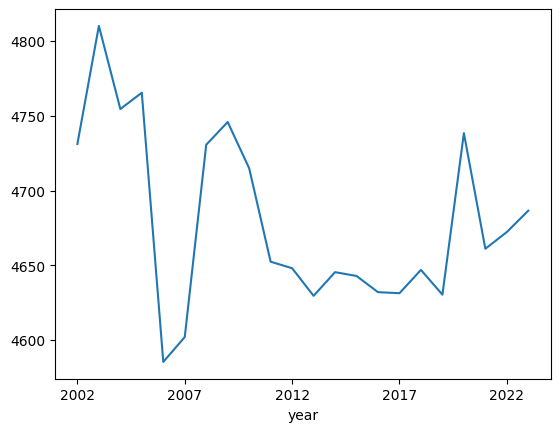

In [ ]:
measurements_info_average_2002_2023['WTE'].plot()

In [ ]:
filtered_wells_based_on_sample={}

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

def plot_wells(sample_size):
    if uploaded_gdf is None:
        print("No shapefile loaded. Please upload a zipped shapefile first.")
        return

    # Precompute the well counts efficiently using groupby
    well_counts = measurements_info.groupby('Well_ID').size()

    # Filter wells based on sample size
    filtered_unique_wells = well_counts[well_counts > sample_size].index.tolist()
    filtered_wells_info[sample_size]=filtered_unique_wells
    # Create a plot for the loaded shapefile
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Color wells_gdf based on the 'State' column
    unique_states = wells_gdf['State'].unique()
    state_colors = plt.cm.get_cmap('tab20', len(unique_states))  # Color map for unique states
    state_color_dict = {state: state_colors(i) for i, state in enumerate(unique_states)}

    # Plot the uploaded shapefile on ax1 and wells with state-based coloring
    uploaded_gdf.plot(ax=ax1, edgecolor='black', facecolor='lightblue')
    for state, color in state_color_dict.items():
        state_gdf = wells_gdf[wells_gdf['State'] == state]
        state_gdf.plot(ax=ax1, edgecolor='black', facecolor=color, label=state)

    # Plot the uploaded shapefile on ax2
    uploaded_gdf.plot(ax=ax2, edgecolor='black', facecolor='lightblue')

    # Plot filtered wells with state-based coloring on ax2
    for state, color in state_color_dict.items():
        filtered_state_gdf = wells_gdf[wells_gdf['State'] == state]
        filtered_state_gdf[filtered_state_gdf['Well_ID'].isin(filtered_unique_wells)].plot(ax=ax2,
                                                                                             edgecolor='black',
                                                                                             facecolor=color,
                                                                                             label=state)

    # Titles and labels for both subplots
    ax1.set_title(f"Imported Shapefile with Well States  ",)
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax2.set_title(f"Filtered Wells by State that has atleast {sample_size} Samples. Remaining wells: {len(filtered_unique_wells)} ",)

    filtered_wells_based_on_sample[sample_size]=filtered_unique_wells
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    print('Remaining wells:', len(filtered_unique_wells))

    # Add a legend for the states
    ax2.legend(title="States", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    print('Processing is done! Remaining wells:', len(filtered_unique_wells))


In [ ]:
measurements_info.to_csv('measurements_info_gse_less_than_wte.csv')

In [ ]:
from ipywidgets import interactive # import the interactive function

sample_widget = widgets.FloatSlider(
    value=0,
    min=minimum_sample_size,
    max=maximum_sample_size,
    step=1,
    description='Sample Size:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)
interactive_widget = interactive(plot_wells, sample_size=sample_widget)
interactive_widget

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Sample Size:', readout_form…

In [ ]:
filtered_wells_key=np.unique(list(filtered_wells_info.keys())).astype(int)

In [ ]:
filtered_wells_key

array([ 0,  5, 10])

In [ ]:
filtered_wells_based_on_sample[5]

In [ ]:
def self_learning_pauta(time_series, window_size, threshold):
    """
    A placeholder for the self_learning_pauta outlier detection algorithm.
    It marks outliers based on a window size and a threshold.
    """
    outliers = [1] * len(time_series)  # Initialize all as not outliers
    for i in range(len(time_series)):
        if i < window_size:
             continue # Skip until we have a full window
        window = time_series[i - window_size:i]
        mean = np.mean(window)
        std = np.std(window)
        if std == 0: # Avoid divide by zero errors if there is no variance in the window
           continue
        if np.abs(time_series[i] - mean) > threshold * std: # Apply Pauta criterion
            outliers[i] = -1
    return outliers
def decomposition(time_series, window_size, threshold):
    """

    """
    decompositions = seasonal_decompose(time_series, model='additive', period=window_size)

    outliers = [1] * len(time_series)  # Initialize all as not outliers
    # Get the residuals
    residuals = decomposition.resid

    # Calculate the z-scores
    z_scores = (residuals - np.mean(residuals)) / np.std(residuals)

    # Identify outliers
    outliers = time_series[np.abs(z_scores) > 3]
    return outliers

In [ ]:
well_info_with_outliers = pd.DataFrame(columns=['keys','outlier','method','Well_ID'])

In [ ]:
well_info_with_outliers

,keys,outlier,method,Well_ID


In [ ]:
measurements_info

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE
0,1,381033113480701,2012-09-06,7092.99,UT,7121.06322,7122.70364,7119.42280
2,1,381152113442801,1995-11-22,6200.00,UT,6555.11832,6551.83748,6558.39916
3,1,381236113485601,2014-07-23,7151.00,UT,7186.68002,7178.47792,7194.88212
4,1,382113113435401,2008-09-03,5395.95,UT,5785.76134,5784.12092,5787.40176
5,1,382113113435401,2008-12-03,5396.10,UT,5785.76134,5784.12092,5787.40176
...,...,...,...,...,...,...,...,...
177204,1,421301111023201,1995-06-09,6068.49,WY,6105.64324,6099.08156,6112.20492
177205,1,421441111023001,1998-08-05,6071.14,WY,6176.18130,6174.54088,6177.82172
177206,1,421441111023001,1999-04-05,6067.09,WY,6176.18130,6174.54088,6177.82172
177207,1,421452111011201,1976-11-10,6956.00,WY,6960.30206,6958.66164,6961.94248


In [ ]:
measurements_info['elevation_difference']=measurements_info['Avg_GSE']-measurements_info['WTE']

In [ ]:
# measurements_info=measurements_info[measurements_info['elevation_difference']>-10]

In [ ]:
import plotly.express as px
from IPython.display import display, HTML
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

def detect_outliers(method, data, window_size, threshold):
    """
    Detect outliers using the specified method: iForest, OCSVM, or KNN.
    """
    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    # Get the number of samples in the data
    n_samples = len(data)

    if method == "iForest":
        # Ensure threshold is a float between 0.0 and 0.5
        if not (0.0 < threshold <= 0.5):
            raise ValueError("Threshold for iForest must be a float between 0.0 and 0.5.")
        model = IsolationForest(contamination=threshold, random_state=42)
        model.fit(scaled_data)
        outliers = model.predict(scaled_data)

    elif method == "OCSVM":
        model = OneClassSVM(nu=threshold, kernel='rbf', gamma='scale')
        model.fit(scaled_data)
        outliers = model.predict(scaled_data)

    elif method == "KNN":
        # Adjust window_size if it's greater than the number of samples
        window_size = min(window_size, n_samples) # This line ensures window_size <= n_samples

        model = NearestNeighbors(n_neighbors=window_size)
        model.fit(scaled_data)
        distances, indices = model.kneighbors(scaled_data)
        avg_dist = distances.mean(axis=1)
        outliers = (avg_dist > threshold).astype(int)


        # mu = np.mean(avg_dist)
        # sigma = np.std(avg_dist)
        # threshold_std = mu + 2 * sigma

        # threshold_pct = np.percentile(avg_dist, 95)

        # # Combine outlier conditions using logical OR
        # outliers = (avg_dist > threshold_std) | (avg_dist > threshold_pct)

        # # Return -1 for outliers, 1 for inliers
        # return np.where(outliers, -1, 1)

    elif method == "SLP":

        outliers=self_learning_pauta(scaled_data, window_size, threshold)
    elif method == "STL":

        outliers=decomposition(scaled_data, window_size, threshold)
        seasonal_decompose(scaled_data, model='additive', period=365)
    elif method=='IQR':
      k=1.5

      # Apply optional thresholds
      q1, q3 = np.percentile(scaled_data, [25, 75]) # Add the 'q' argument with desired percentiles
      iqr = q3 - q1
      lower_bound = q1 - k * iqr
      upper_bound = q3 + k * iqr

      outliers = (scaled_data < lower_bound) | (scaled_data > upper_bound)
      outliers= np.where(outliers, -1, 1)



    else:
        raise ValueError("Invalid outlier detection method. Choose 'iForest', 'OCSVM', or 'KNN'.")
    return outliers

def time_series_plot(keys, well_id, window_size, threshold, method):
    # filtered_measurements = measurements[measurements['Well_ID'].isin(filtered_wells_info[key])]
    filtered_measurements = measurements_info[measurements_info['Well_ID'] == well_id].copy()  # Explicit copy

    # Ensure the date column is in datetime format
    filtered_measurements.loc[:, ts_date.value] = pd.to_datetime(
        filtered_measurements[ts_date.value], errors='coerce'
    )
    # global well_info_with_outliers
    # Drop NaT values
    filtered_measurements = filtered_measurements.dropna(subset=[ts_date.value])

    # Sort data by date
    filtered_measurements = filtered_measurements.sort_values(by=ts_date.value)

    global well_info_with_outliers
    # Detect outliers
    outliers = detect_outliers(method, filtered_measurements[ts_measurement.value], window_size, threshold)
    if -1 in outliers :
      filtered_measurements['outlier']=outliers

      # negative_indices = filtered_measurements[filtered_measurements['outlier']==-1]
      # print(negative_indices)

      # outlier_dates = filtered_measurements.loc[negative_indices, 'Date'].to_list()

      # well_info_with_outliers['keys']=keys
      # well_info_with_outliers['method']=method
      # well_info_with_outliers['Well_ID']=well_id
      # well_info_with_outliers['Date']=filtered_measurements['Date']
      # well_info_with_outliers['WTE']=filtered_measurements['WTE']
      new_entry = pd.DataFrame({
            'keys': keys,
            'dates': filtered_measurements['Date'].to_list(),
            'index':filtered_measurements.index.to_list(),
            'method': method,
            'Well_ID': well_id,
            'wte':filtered_measurements['WTE'].to_list(),
            'outlier':filtered_measurements['outlier'].to_list()
        })
      print(well_info_with_outliers)
      well_info_with_outliers = pd.concat([well_info_with_outliers, new_entry], ignore_index=True)





    # # print('outlier_dates',outlier_dates)

    # # Add outlier column
    # # filtered_measurements.loc[:, 'Outlier'] = outliers
    # global well_info_with_outliers
    # # Store the processed data
    # if -1 in outliers :
    #   # print('Outliers detected at well id :',well_id)
    #   # print('Outliers detected at well id :',well_id)
    #   new_entry = pd.DataFrame({
    #         'keys': keys,
    #         'outlier_dates': date,
    #         'method': method,
    #         'Well_ID': well_id
    #     })
    #   print(well_info_with_outliers)
    #   well_info_with_outliers = pd.concat([well_info_with_outliers, new_entry], ignore_index=True)
    #   # print(well_info_with_outliers)

    # else:
    #   print('No outliers detected at well id :',well_id)


    return
    # Create the plot
    # fig = px.line(filtered_measurements, x=ts_date.value, y=ts_measurement.value,
    #               title=f"Time Series for Well ID: {filtered_wells_info[keys][0]}. The well has {len(filtered_measurements)} samples")

    # # Highlight outliers by changing their color (correctly aligning them)
    # outlier_points = filtered_measurements[filtered_measurements['Outlier'] == -1]
    # customdata=outlier_points[[ts_date.value, ts_measurement.value]]
    # if not outlier_points.empty:
    #     fig.add_scatter(
    #         x=outlier_points[ts_date.value],
    #         y=outlier_points[ts_measurement.value],
    #         mode='markers',
    #         name='Outliers',
    #         marker=dict(color='red', size=10),
    #         customdata=outlier_points[[ts_date.value, ts_measurement.value]],  # Add custom data for outliers
    #         hovertemplate='Date: %{customdata[0]}<br>Value: %{customdata[1]}'  # Hover template for outliers
    #     )



    # # Adjust x-axis for date formatting
    # fig.update_layout(
    #     xaxis=dict(
    #         type='date',  # Ensure the x-axis is treated as a date
    #         title='Date',  # Label for the x-axis
    #         tickformat="%Y-%m-%d",  # Adjust date format for readability
    #         tickangle=45  # Rotate tick labels for better legibility
    #     ),
    #     yaxis=dict(
    #         title=ts_measurement.value  # Label for the y-axis
    #     )
    # )

    # fig.show()


In [ ]:

#iForest
for i in filtered_wells_key[1:]:
  print(i)


  for j in filtered_wells_info[i]:

    time_series_plot(i,j,12,0.05,method="iForest")



In [ ]:
well_info_5=well_info_with_outliers[(well_info_with_outliers['keys']==5)]
well_info_10=well_info_with_outliers[(well_info_with_outliers['keys']==10)]

In [ ]:
well_info_5_no_outliers=well_info_5[well_info_5['outlier']==1]
well_info_5_with_outliers=well_info_5[well_info_5['outlier']==-1]
well_info_10_no_outliers=well_info_10[well_info_10['outlier']==1]
well_info_10_with_outliers=well_info_10[well_info_10['outlier']==-1]

In [ ]:
well_info_5_with_outliers

,keys,outlier,method,Well_ID,dates,index,wte
0,5,-1,iForest,382113113435401,2008-09-03,4.0,5395.95
32,5,-1,iForest,382113113435401,2023-03-29,36.0,5398.74
33,5,-1,iForest,382259113433701,1978-06-09,39.0,5316.00
66,5,-1,iForest,382259113433701,2023-03-29,72.0,5318.71
77,5,-1,iForest,382402113421101,2023-03-29,83.0,4967.26
...,...,...,...,...,...,...,...
167374,5,-1,iForest,424340111344101,2003-09-10,175538.0,5992.49
167376,5,-1,iForest,424340111344101,2004-09-13,175540.0,5992.77
167378,5,-1,iForest,424340111344101,2005-09-15,175542.0,5993.35
167382,5,-1,iForest,424340111344101,2007-09-17,175546.0,5994.17


In [ ]:
outlier_index_5=measurements_info[measurements_info.index.isin(well_info_5_with_outliers['index'])]['outlier'].index.to_list()

In [ ]:
measurements_info.loc[outlier_index_5,'outlier']=-1

In [ ]:
measurements_info.loc[measurements_info['outlier'] == -1, 'WTE'] = np.nan


In [ ]:
measurements_info.to_csv('measurements_info_gse_less_than_wte_and_all_outliers.csv')

In [ ]:
well_info_5_no_outliers_grouped=well_info_5_no_outliers.groupby('Well_ID')['wte'].mean().rename('WTE').reset_index()

In [ ]:
well_info_5

,keys,outlier,method,Well_ID,dates,index,wte,new_outlier,wte_diff,avg_wte
0,5,-1,iForest,382113113435401,2008-09-03,4.0,5395.95,1,-1.380968,5397.330968
1,5,1,iForest,382113113435401,2008-12-03,5.0,5396.10,1,-1.230968,5397.330968
2,5,1,iForest,382113113435401,2009-03-03,6.0,5396.45,1,-0.880968,5397.330968
3,5,1,iForest,382113113435401,2009-06-10,7.0,5396.44,1,-0.890968,5397.330968
4,5,1,iForest,382113113435401,2009-09-16,8.0,5396.35,1,-0.980968,5397.330968
...,...,...,...,...,...,...,...,...,...,...
167381,5,1,iForest,424340111344101,2007-03-19,175545.0,6000.39,1,0.271054,6000.118946
167382,5,-1,iForest,424340111344101,2007-09-17,175546.0,5994.17,1,-5.948946,6000.118946
167383,5,1,iForest,424340111344101,2008-04-09,175547.0,5995.66,1,-4.458946,6000.118946
167384,5,-1,iForest,424340111344101,2008-09-03,175548.0,5993.30,1,-6.818946,6000.118946


In [ ]:
well_info_5_no_outliers_grouped

,Well_ID,WTE
0,382113113435401,5397.330968
1,382259113433701,5317.518750
2,382402113421101,4965.630000
3,383023114115302,5663.871304
4,383325114134901,5654.461000
...,...,...
2211,423433111484701,5423.621461
2212,423504111482801,5415.752083
2213,423652111463001,5420.983333
2214,423806111371601,5728.902857


In [ ]:
well_info_5_no_outliers_grouped[well_info_5_no_outliers_grouped['Well_ID']==383533114102901]

,Well_ID,WTE
7,383533114102901,5583.093


In [ ]:
# Create a mapping of Well_ID to WTE from well_info_5_no_outliers_grouped
wte_no_outliers_map = well_info_5_no_outliers_grouped.set_index('Well_ID')['WTE'].to_dict()

# Initialize new_outlier column with 1
well_info_5['new_outlier'] = 1

# # Calculate the difference using vectorized operations
well_info_5['wte_diff'] = well_info_5['wte'] - well_info_5['Well_ID'].map(wte_no_outliers_map)
well_info_5['avg_wte']=well_info_5['Well_ID'].map(wte_no_outliers_map)
# # Check if the difference exceeds the threshold and assign -1 to new_outlier

# # Set new_outlier to -1 where the difference exceeds the threshold
well_info_5.loc[abs(well_info_5['wte_diff']) > 20, 'new_outlier'] = -1

# # Drop the temporary wte_diff column if not needed
# well_info_5.drop('wte_diff', axis=1, inplace=True)


In [ ]:
well_info_5_outlier=well_info_5[well_info_5['new_outlier']==-1]

In [ ]:
well_info_5_outlier

,keys,outlier,method,Well_ID,dates,index,wte,new_outlier,wte_diff,avg_wte
263,5,-1,iForest,383533114102901,2014-02-24,175706.0,5653.00,-1,69.907000,5583.093000
887,5,-1,iForest,385607114015601,1977-09-08,543.0,5185.01,-1,-21.751696,5206.761696
898,5,-1,iForest,385607114015601,1983-09-08,554.0,5232.29,-1,25.528304,5206.761696
952,5,-1,iForest,385607114015601,2013-09-10,608.0,5183.84,-1,-22.921696,5206.761696
956,5,-1,iForest,385607114015601,2014-09-16,612.0,5181.97,-1,-24.791696,5206.761696
...,...,...,...,...,...,...,...,...,...,...
166424,5,1,iForest,423504111482801,1982-06-15,174496.0,5389.86,-1,-25.892083,5415.752083
166425,5,-1,iForest,423504111482801,1982-07-26,174497.0,5395.13,-1,-20.622083,5415.752083
166432,5,-1,iForest,423504111482801,1983-07-06,174504.0,5390.09,-1,-25.662083,5415.752083
166475,5,-1,iForest,423504111482801,1990-07-19,174547.0,5389.39,-1,-26.362083,5415.752083


In [ ]:
measurements_info['outlier']=1

In [ ]:
outlier_index=measurements_info[measurements_info.index.isin(well_info_5_outlier['index'])]['outlier'].index.to_list()

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,outlier,elevation_difference


In [ ]:
measurements_info.loc[outlier_index,'outlier']=-1

In [ ]:
measurements_info[measurements_info['outlier']==-1]

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,elevation_difference,outlier
543,1,385607114015601,1977-09-08,5185.01,UT,5275.59072,5278.87156,5272.30988,90.58072,-1
554,1,385607114015601,1983-09-08,5232.29,UT,5275.59072,5278.87156,5272.30988,43.30072,-1
608,1,385607114015601,2013-09-10,5183.84,UT,5275.59072,5278.87156,5272.30988,91.75072,-1
612,1,385607114015601,2014-09-16,5181.97,UT,5275.59072,5278.87156,5272.30988,93.62072,-1
656,1,385617114013801,1976-09-22,5183.47,UT,5252.62484,5252.62484,5252.62484,69.15484,-1
...,...,...,...,...,...,...,...,...,...,...
176291,1,404426114053501,1987-10-02,4539.65,NV,4711.28624,4708.00540,4714.56708,171.63624,-1
176302,1,405142114114001,1984-04-18,4470.49,NV,4509.51458,4504.59332,4514.43584,39.02458,-1
176362,1,411554114255801,1989-11-22,6126.36,NV,6128.60912,6131.88996,6125.32828,2.24912,-1
176368,1,411732114365201,1968-09-12,5708.00,NV,5815.28890,5816.92932,5813.64848,107.28890,-1


In [ ]:
measurements_info.loc[measurements_info['outlier'] == -1, 'WTE'] = np.nan


In [ ]:
measurements_info.drop(columns=['outlier'], inplace=True)

In [ ]:
measurements_info.to_csv('measurements_info_gse_less_than_wte_and_removed_plus_higher_and_lower.csv')

In [ ]:


for index, row in well_info_5_outlier.iterrows():
    well_id = row['Well_ID']
    date = row['dates']  # Access the 'dates' column

    # Find matching rows in measurements_info
    matching_rows = measurements_info[(measurements_info['Well_ID'] == well_id) & (measurements_info['Date'] == date)]

    # Change the value in 'measurement_info' to -1 (Assuming you want to modify a specific column)
    # Replace 'measurement_column' with the actual column name you want to modify
    if not matching_rows.empty:
        measurements_info.loc[matching_rows.index, 'outlier'] = -1


In [ ]:
# Merge well_info_5_outlier and measurements_info on 'Well_ID' and 'Date'
# Ensure both 'dates' and 'Date' columns are of datetime64[ns] type
# merged_data = well_info_5_outlier[['Well_ID', 'dates']].merge(
#     measurements_info,
#     left_on=['Well_ID', 'dates'],
#     right_on=['Well_ID', pd.to_datetime(measurements_info['Date'])],  # Convert 'Date' to datetime64[ns]
#     how='inner'
# )

# # Reset index of merged_data before using it to access measurements_info
# merged_data = merged_data.reset_index(drop=True)

# Set the 'outlier' column to -1 for the matching rows, using the index from measurements_info
measurements_info[measurements_info.index.isin(well_info_5_outlier['index'])]['outlier'] = -1
# measurements_info.loc[well_info_5_outlier.index==263, 'outlier'] = -1
# measurements_info.loc[merged_data.index, 'outlier'] = -1

<ipython-input-182-261fa2502093>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurements_info[measurements_info.index.isin(well_info_5_outlier['index'])]['outlier'] = -1


In [ ]:
# prompt: measurements_info['outlier']==-1 assign it as nan

measurements_info.loc[measurements_info['outlier'] == -1, 'outlier'] = np.nan


In [ ]:
measurements_info.isna().sum()

,0
AquiferID,0
Well_ID,0
Date,0
WTE,0
State,0
Avg_GSE,0
NASA_GSE,0
AW3D_GSE,0
outlier,3193
elevation_difference,0


In [ ]:
measurements_info.to_csv('measurements_info_gse_less_than_wte_and_removed_higher_positive.csv')

In [ ]:
extreme_outlier['outlier']=-1

<ipython-input-158-7d14304b71d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_outlier['outlier']=-1


In [ ]:
extreme_outlier.iloc[:,0:-3]

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,outlier,elevation_difference
1,1,381037113474001,2012-09-06,7175.95,UT,7117.78238,7122.70364,7112.86112,-1,-58.16762
1263,1,390530113590001,1936-11-01,5086.00,UT,5000.00016,4993.43848,5006.56184,-1,-85.99984
1352,1,390600113591501,1936-10-01,5073.00,UT,4990.15764,4986.87680,4993.43848,-1,-82.84236
9773,1,395310111530101,1965-04-08,4981.00,UT,4945.86630,4940.94504,4950.78756,-1,-35.13370
9774,1,395310111530101,1965-11-19,4987.40,UT,4945.86630,4940.94504,4950.78756,-1,-41.53370
...,...,...,...,...,...,...,...,...,...,...
176642,1,412726114110701,1956-09-13,5970.00,NV,5026.24688,5019.68520,5032.80856,-1,-943.75312
176645,1,412835114120501,1957-04-25,5077.00,NV,5049.21276,5052.49360,5045.93192,-1,-27.78724
176646,1,412835114120501,2002-07-24,5069.76,NV,5049.21276,5052.49360,5045.93192,-1,-20.54724
176650,1,413249114292901,1955-08-19,5595.00,NV,5398.62222,5390.42012,5406.82432,-1,-196.37778


In [ ]:
all_merged = pd.concat([measurements_info, extreme_outlier.iloc[:,0:-3]]) # Enclose the DataFrames in a list


In [ ]:
all_merged.to_csv('all_merged_with_outliers.csv')

In [ ]:
all_merged.loc[all_merged['outlier'] == -1, 'WTE'] = np.nan


In [ ]:
all_merged

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,outlier,elevation_difference
0,1,381033113480701,2012-09-06,NaN,UT,7121.06322,7122.70364,7119.42280,-1,28.07322
2,1,381152113442801,1995-11-22,NaN,UT,6555.11832,6551.83748,6558.39916,-1,355.11832
3,1,381236113485601,2014-07-23,NaN,UT,7186.68002,7178.47792,7194.88212,-1,35.68002
4,1,382113113435401,2008-09-03,NaN,UT,5785.76134,5784.12092,5787.40176,-1,389.81134
5,1,382113113435401,2008-12-03,NaN,UT,5785.76134,5784.12092,5787.40176,-1,389.66134
...,...,...,...,...,...,...,...,...,...,...
176642,1,412726114110701,1956-09-13,NaN,NV,5026.24688,5019.68520,5032.80856,-1,-943.75312
176645,1,412835114120501,1957-04-25,NaN,NV,5049.21276,5052.49360,5045.93192,-1,-27.78724
176646,1,412835114120501,2002-07-24,NaN,NV,5049.21276,5052.49360,5045.93192,-1,-20.54724
176650,1,413249114292901,1955-08-19,NaN,NV,5398.62222,5390.42012,5406.82432,-1,-196.37778


In [ ]:
all_merged.to_csv('all_merged_with_outliers_nan.csv')


In [ ]:
measurements_info[measurements_info['outlier']==-1]

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,outlier,elevation_difference
0,1,381033113480701,2012-09-06,7092.99,UT,7121.06322,7122.70364,7119.42280,-1,28.07322
2,1,381152113442801,1995-11-22,6200.00,UT,6555.11832,6551.83748,6558.39916,-1,355.11832
3,1,381236113485601,2014-07-23,7151.00,UT,7186.68002,7178.47792,7194.88212,-1,35.68002
4,1,382113113435401,2008-09-03,5395.95,UT,5785.76134,5784.12092,5787.40176,-1,389.81134
5,1,382113113435401,2008-12-03,5396.10,UT,5785.76134,5784.12092,5787.40176,-1,389.66134
...,...,...,...,...,...,...,...,...,...,...
4312,1,394112111522401,1988-03-04,5006.06,UT,5021.32562,5019.68520,5022.96604,-1,15.26562
4313,1,394112111522401,1989-03-02,5000.78,UT,5021.32562,5019.68520,5022.96604,-1,20.54562
4314,1,394112111522401,1990-03-01,4993.85,UT,5021.32562,5019.68520,5022.96604,-1,27.47562
4315,1,394112111522401,1991-03-04,4990.77,UT,5021.32562,5019.68520,5022.96604,-1,30.55562


In [ ]:
measurements_info

,AquiferID,Well_ID,Date,WTE,State,Avg_GSE,NASA_GSE,AW3D_GSE,outlier,elevation_difference
0,1,381033113480701,2012-09-06,7092.99,UT,7121.06322,7122.70364,7119.42280,-1,28.07322
2,1,381152113442801,1995-11-22,6200.00,UT,6555.11832,6551.83748,6558.39916,-1,355.11832
3,1,381236113485601,2014-07-23,7151.00,UT,7186.68002,7178.47792,7194.88212,-1,35.68002
4,1,382113113435401,2008-09-03,5395.95,UT,5785.76134,5784.12092,5787.40176,-1,389.81134
5,1,382113113435401,2008-12-03,5396.10,UT,5785.76134,5784.12092,5787.40176,-1,389.66134
...,...,...,...,...,...,...,...,...,...,...
177204,1,421301111023201,1995-06-09,6068.49,WY,6105.64324,6099.08156,6112.20492,1,37.15324
177205,1,421441111023001,1998-08-05,6071.14,WY,6176.18130,6174.54088,6177.82172,1,105.04130
177206,1,421441111023001,1999-04-05,6067.09,WY,6176.18130,6174.54088,6177.82172,1,109.09130
177207,1,421452111011201,1976-11-10,6956.00,WY,6960.30206,6958.66164,6961.94248,1,4.30206


In [ ]:
well_info_5[(well_info_5['wte_diff']<-20) & (well_info_5['outlier']==1)]

,keys,outlier,method,Well_ID,dates,wte,new_outlier,wte_diff,avg_wte
0,5,-1,iForest,382113113435401,2008-09-03,5395.95,1,-1.380968,5397.330968
32,5,-1,iForest,382113113435401,2023-03-29,5398.74,1,1.409032,5397.330968
33,5,-1,iForest,382259113433701,1978-06-09,5316.00,1,-1.518750,5317.518750
66,5,-1,iForest,382259113433701,2023-03-29,5318.71,1,1.191250,5317.518750
77,5,-1,iForest,382402113421101,2023-03-29,4967.26,1,1.630000,4965.630000
...,...,...,...,...,...,...,...,...,...
167374,5,-1,iForest,424340111344101,2003-09-10,5992.49,1,-7.628946,6000.118946
167376,5,-1,iForest,424340111344101,2004-09-13,5992.77,1,-7.348946,6000.118946
167378,5,-1,iForest,424340111344101,2005-09-15,5993.35,1,-6.768946,6000.118946
167382,5,-1,iForest,424340111344101,2007-09-17,5994.17,1,-5.948946,6000.118946


In [ ]:
well_info_with_outliers.to_csv('well_info_with_outliers_iforest_more1.csv')

In [ ]:
well_info_with_outliers=pd.read_csv('well_info_with_outliers_iforest.csv')

In [ ]:
well_info_with_outliers

,keys,outlier,method,Well_ID,dates,wte
0,5,-1,iForest,382113113435401,2008-09-03,5395.95
1,5,1,iForest,382113113435401,2008-12-03,5396.10
2,5,1,iForest,382113113435401,2009-03-03,5396.45
3,5,1,iForest,382113113435401,2009-06-10,5396.44
4,5,1,iForest,382113113435401,2009-09-16,5396.35
...,...,...,...,...,...,...
645930,20,1,iForest,424340111344101,2007-03-19,6000.39
645931,20,-1,iForest,424340111344101,2007-09-17,5994.17
645932,20,1,iForest,424340111344101,2008-04-09,5995.66
645933,20,-1,iForest,424340111344101,2008-09-03,5993.30


GIF saved as well_animation_with_outliers_iforest_more1.gif


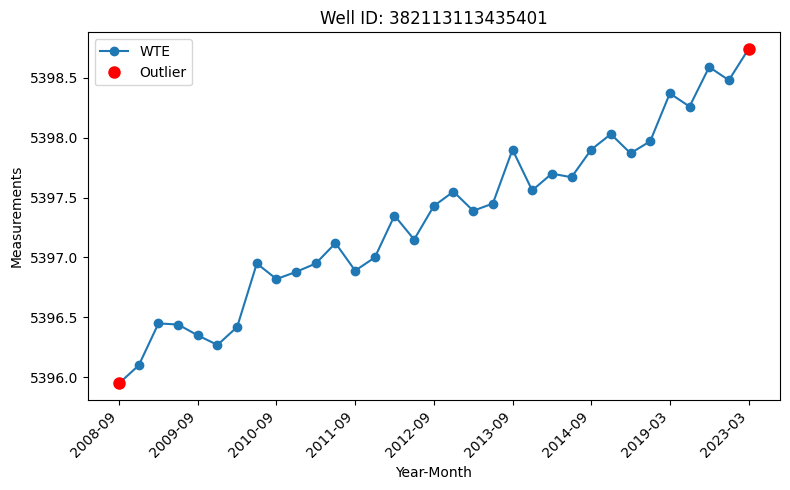

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
from IPython.display import HTML
iforest=well_info_with_outliers[well_info_with_outliers['keys']==5]
# Ensure 'above_gse' DataFrame is defined before running this
unique_wells = iforest['Well_ID'].unique()

fig, ax = plt.subplots(figsize=(8, 5))  # Adjust figure size for better readability

def animate(i):
    ax.clear()
    current_well = unique_wells[i % len(unique_wells)]
    well_data = iforest[iforest['Well_ID'] == current_well].copy()

    # Convert 'Date' column to datetime if not already
    well_data['dates'] = pd.to_datetime(well_data['dates'])

    # Now you can use .dt to get the Year-Month
    well_data['Year-Month'] = well_data['dates'].dt.to_period('M').astype(str)

    # Plot WTE data
    ax.plot(well_data['Year-Month'], well_data['wte'], label='WTE', marker='o', linestyle='-')

    # Plot GSE as a horizontal line
    # avg_gse = well_data['Avg_GSE'].iloc[0]  # Assuming GSE is constant for a well
    # ax.axhline(y=avg_gse, color='gray', linestyle='--', linewidth=2, label="Avg GSE")

    # Mark outliers
    outliers = well_data[well_data['outlier'] ==-1]
    if not outliers.empty:
        ax.plot(outliers['Year-Month'], outliers['wte'], 'ro', label='Outlier', markersize=8)

    # Formatting x-axis (Year-Month)
    ax.set_title(f"Well ID: {current_well}")
    ax.set_xlabel("Year-Month")
    ax.set_ylabel("Measurements")

    # Set tick spacing to avoid clutter
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))  # Prune labels at start & end

    plt.xticks(rotation=45, ha='right')  # Rotate for readability

    ax.legend()
    plt.tight_layout()

# Increase animation size limit
plt.rcParams['animation.embed_limit'] = 100  # Set to 50MB

ani = animation.FuncAnimation(fig, animate, frames=len(unique_wells))

# Save as GIF
gif_path = "well_animation_with_outliers_iforest_more1.gif"
ani.save(gif_path, writer='pillow', fps=2)  # Adjust FPS if needed

print(f"GIF saved as {gif_path}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
well_info_with_outliers

,keys,outlier_dates,method,Well_ID
0,5,[2019-03-26 00:00:00],iForest,382113113435401
1,5,[],iForest,382259113433701
2,5,[],iForest,382402113421101
3,5,[],iForest,383023114115302
4,5,[],iForest,383325114134901
...,...,...,...,...
6506,20,[],iForest,423045111450001
6507,20,[],iForest,423433111484701
6508,20,[],iForest,423504111482801
6509,20,[],iForest,423652111463001


In [ ]:
# Example usage: using iForest for outlier detection
time_series_plot(keys, well_id, window_size=20, threshold=0.05, method="iForest")


In [ ]:
import pandas as pd
import numpy as np

def self_learning_pauta(data, window_size, threshold=3):
    """
    Detects outliers in a time series using the self-learning Pauta criterion.

    Args:
        data (list or np.array): Time series data.
        window_size (int): Size of the moving window.
        threshold (float): Number of standard deviations to consider as an outlier.

    Returns:
        list: Boolean list indicating outliers (True for outlier, False for normal).
    """
    outliers = [False] * len(data)  # Initialize all as not outliers
    for i in range(len(data)):
        if i < window_size:
             continue # Skip until we have a full window
        window = data[i - window_size:i]
        mean = np.mean(window)
        std = np.std(window)
        if std == 0: # Avoid divide by zero errors if there is no variance in the window
           continue
        if np.abs(data[i] - mean) > threshold * std: # Apply Pauta criterion
            outliers[i] = True
    return outliers


In [ ]:
self_learning_pauta(keys, well_id, window_size=20, threshold=0.05, method="iForest")


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Data
x = np.array([12.62
-7.77
-194.26
-347.36
115.48
107.40
205.23
113.53
-91.96
148.52
160.26
-38.52
-246.47
-291.34
-447.94
-412.12
-335.50
-18.58
-325.81
-610.81
-862.70
-698.12
]).reshape(-1, 1)
y = np.array([-2.936397283
-3.348814658
-2.300211052
-0.64784083
0.470888734
-0.71717386
1.595163352
1.599173656
0.871622748
4.024052627
-1.136303672
-5.762817639
-7.372707076
-7.951948816
-8.12435808
-7.511084839
-9.449591838
-6.497254004
-8.601532513
-9.728631352
-7.933523845
-6.592931906])

# Fit Linear Regression Model
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Calculate RSS and TSS
rss = np.sum((y - y_pred)**2)
tss = np.sum((y - np.mean(y))**2)

# Calculate R-squared
r_squared = 1 - (rss / tss)

print(f"R-squared: {r_squared}")


SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-41-10d76dcc24f7>, line 5)